In [4]:
# python imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import math
import wandb

In [5]:
#torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [6]:
#tf/keras imports
import kerastuner
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from wandb.keras import WandbCallback

# Data preperation
V tejto sekcii si pripravime data na feeding neuronovej siete.

In [7]:
# funkcia na vykreslenie validacnych grafov
def validation_graphs(a,b=None, sample_size=15):
    # set sample size
    # draw bar charts
    plt.figure(figsize=(10, 8))
    plt.bar(range(sample_size),y_test['MV'][:sample_size],color="#f2b750",label="Actual values")
    plt.bar(range(sample_size),a.flatten()[:sample_size],color="#4a7fe8", width=0.45, label='PyTorch predicted values')
    plt.bar(range(sample_size),b.flatten()[:sample_size],color="#4acce8", width=0.2,label="TF predicted values")

    plt.legend(loc="upper right")
    plt.title("Vizualizácia evaluácie modelu")
    plt.show()
    # calc error
    error = abs(y_valid - a)
    sns.distplot(error).set_title("Distribúcia štandartnej odchýlky PYTORCH")
    plt.show()
    error = abs(y_valid - b)
    sns.distplot(error).set_title("Distribúcia štandartnej odchýlky KERAS")
    plt.show()

In [8]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ramang (use `wandb login --relogin` to force relogin)


True

In [9]:
def loadData():
    return pd.read_excel('data/boston.xls')  


In [10]:
df = loadData()

In [11]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PT,B,LSTAT,MV
0,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,396.899994,4.98,24.000000
1,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,396.899994,9.14,21.600000
2,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,392.829987,4.03,34.700001
3,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,394.630005,2.94,33.400002
4,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,396.899994,5.33,36.200001


In [12]:
X = list(df.columns)
X.remove("MV")
y = ["MV"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test[X], y_test[y], random_state=42)

Jednotlivé stĺpce v datasete treba najskôr škálovať na interval (-1, 1).

In [14]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)
X_valid = min_max_scaler.fit_transform(X_valid)

# KERAS/TensorFlow

Sekcia zadania v ktorej pracujeme s návrhom neurónovej siete v kerase/tf. 

In [15]:
# custom funkcia na vypocet pseudo acc pre regresivny model
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


## Sweep wandb pre keras
Vykonáme wandb sweep. Aby sme dostali najlepšie hyperparemetre. 

In [18]:
sweep_config = {
  "name": "NN-test-sweep-keras",
  "method": "random",
  "metric" : {
    'name': 'loss',
    'goal': 'minimize'   
    },
 "parameters" : {
    'optimizer': {
        'values': ['Adam', 'Adagrad', 'RMSprop']
        },

    'criterion': {
        'values': ['mean_squared_error']
        },

    'h1': {
        'values': [8, 16, 32, 64,256]
        },

    'h2': {
        'values': [8, 16, 32, 64,256]
        },

    'h3': {
        'values': [8, 16, 32, 64,256]
        },

    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
        },

    'batch_size': {
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(32),
        'max': math.log(256),
      },

    'epochs': {
        'distribution': 'int_uniform',
        'min':20,
        'max': 100,
        }
    }   

}

In [19]:
sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: fn81bsbc
Sweep URL: https://wandb.ai/ramang/uncategorized/sweeps/fn81bsbc


Trénovacia funkcia sweepu 

In [20]:
def train():
    with wandb.init(config=sweep_config):
    # Specify the other hyperparameters to the configuration
        config = wandb.config
        # Add the config item (layers) to wandb
        if wandb.run:
            # Define the model
            model = Sequential()

            model.add(Dense(config.h1, activation='relu'))
            model.add(Dense(config.h2, activation='relu'))
            model.add(Dense(config.h3, activation='relu'))
            model.add(Dense(1))

            model.compile(loss=config.criterion, optimizer=config.optimizer,metrics=[soft_acc, metrics.MeanSquaredError()])
            # Train the model
            model.fit(X_train, y_train, epochs=config.epochs,validation_data=(X_test, y_test),callbacks=[WandbCallback()],verbose=0)

In [21]:
# spustenie sweepu
#wandb.agent(sweep_id, function=train, count=20)

## Vytvorenie najlepšiého modelu podľa hyperparametrov


In [22]:
model = Sequential()

model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='RMSprop',metrics=[soft_acc, metrics.MeanSquaredError()])
model.fit(X_train, y_train, epochs=79, verbose=0,validation_data=(X_test, y_test))

# PyTorch

Sekcia zadania v ktorej pouzivame pytorch.


In [23]:
sweep_config = {
  "name": "NN-test-sweep1",
  "method": "random",
  "metric" : {
    'name': 'loss',
    'goal': 'minimize'   
    },
 "parameters" : {
    'optimizer': {
        'values': ['adam', 'ada', 'rms']
        },

    'criterion': {
        'values': ['mse']
        },

    'h1': {
        'values': [8, 16, 32, 64,256]
        },

    'h2': {
        'values': [8, 16, 32, 64,256]
        },

    'h3': {
        'values': [8, 16, 32, 64,256]
        },

    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
        },

    'batch_size': {
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(32),
        'max': math.log(256),
      },

    'epochs': {
        'values': [100,20,30,40,50,80]
        }
    }   

}



In [24]:
# sweep_id = wandb.sweep(sweep_config)

In [25]:
values_y = y_train.values

## Definovanie jednotlivých funkcií pre pytorch wandb sweep

In [26]:
class Model(torch.nn.Module):
    def __init__(self, n_feature,h1, h2, h3):
        super(Model, self).__init__()
        self.input = torch.nn.Linear(n_feature, h1)
        self.hidden = [
            torch.nn.Linear(h1, h2),
            torch.nn.Linear(h2, h3)
        ]            
        self.output = torch.nn.Linear(h3, 1) 

    def forward(self, x):
        x = self.input(x)
        for h in self.hidden:
            x = F.relu(h(x))
        x = self.output(x) 
        return x

        

def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "ada":
        optimizer = torch.optim.Adagrad(network.parameters(),
                              lr=learning_rate)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(network.parameters(),
                               lr=learning_rate)
    elif optimizer == "rms":
        optimizer = torch.optim.RMSprop(network.parameters(),
                            lr=learning_rate)
    return optimizer

def build_criterion(network, criterion):
    if criterion == "mse":
        criterion = torch.nn.MSELoss()

    return criterion


def train_epoch(network, actual, features, batch_size, optimizer, criterion):
    running_loss = 0.0
    batch_no = len(features) // batch_size
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        inputs = Variable(torch.FloatTensor(features[start:end]))
        labels = Variable(torch.FloatTensor(actual[start:end]))
        optimizer.zero_grad()

        outputs = network(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss

        

## Trénovací cyklus pre wandb sweep

In [27]:
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config

        network = Model(len(X), config.h1, config.h2, config.h3)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)
        criterion = build_criterion(network, config.criterion)
        
        for epoch in range(config.epochs):

            loss = train_epoch(network, values_y, X_train, config.batch_size, optimizer,criterion)
            wandb.log({"loss": loss, "epoch": epoch}) 

In [28]:
#wandb.agent(sweep_id, train, count=20)


## Vytvorenie najlepšieho modelu podľa wandb sweep

In [29]:
network = Model(len(X),32, 32, 64)
optimizer = build_optimizer(network, "rms",  0.05250183462519349)
criterion = build_criterion(network, "mse")

for epoch in range(80):
    train_epoch(network, values_y, X_train, 253, optimizer,criterion)

# Overenie modelov
PyTorch a Keras model sme otestovali na validačných dátach a porovnali ich úspešnosť pomocou grafu.

In [32]:
# predikcia pytorch
pyPred = Variable(torch.FloatTensor(X_valid)) 
result = network(pyPred)
pytorch_prediction=result.data.numpy()

# predikcia keras
tf_prediction = model.predict(X_valid)


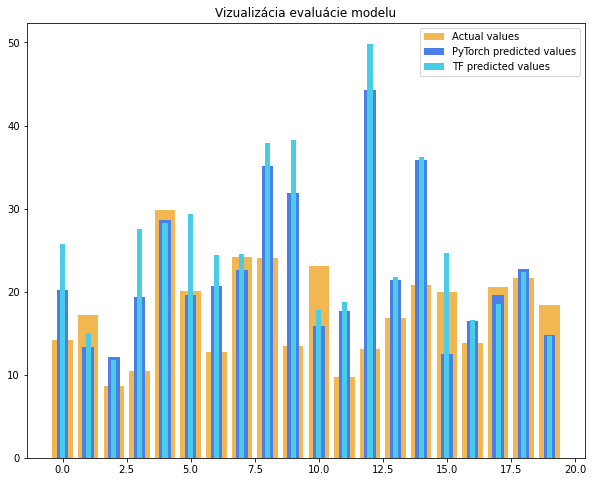

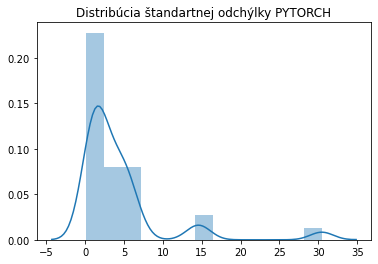

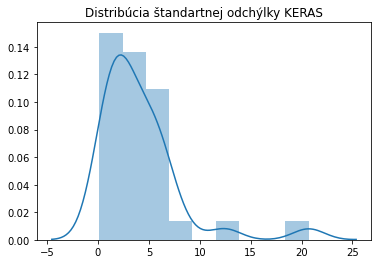

In [31]:
validation_graphs(pytorch_prediction,tf_prediction,sample_size=20)